<a href="https://colab.research.google.com/github/yagvendrasingh/Toxic-comment-classification-problem-using-bert-in-keras/blob/master/final_model_bert_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2nd : Toxic comment classsification

## Problem statement:

In the world full of internet everybody has liberty to write and give their opinion at any social medial platform. people usually choose to write their opinion on website"s comment section and thread section but many times it has observed that rather than giving constructive advise people use this opportunity to bully or abuse others and start fighting with each other in the threads and comment section where they sometimes even give threat and insult each other .To specifically identify and restrict these type of comments internet companies are working very hardly and this competition was also held on similar topic.

## The resources used in this project

1.) https://arxiv.org/pdf/1810.04805.pdf

2.) https://huggingface.co/transformers/model_doc/bert.html

### 1.) Importing all the important libraries

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation, Dropout, Average , BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from transformers import BertTokenizer, TFBertModel , TFBertForSequenceClassification
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
import os
from googletrans import *
from wordcloud import WordCloud , STOPWORDS 
import plotly.graph_objects as go
import plotly.express as px
import string
from nltk.tokenize.treebank import TreebankWordTokenizer
import pickle
from sklearn.metrics import roc_curve
from IPython.display import Image


## Loading And Reading The dataset

In [ ]:
data = pd.read_csv("/gdrive/My Drive/Colab Notebooks/jigsaw-toxic-comment-classification-challenge/train.csv")
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
test_data =  pd.read_csv("/gdrive/My Drive/Colab Notebooks/jigsaw-toxic-comment-classification-challenge/test.csv")
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
test_labels = pd.read_csv("/gdrive/My Drive/Colab Notebooks/jigsaw-toxic-comment-classification-challenge/test_labels.csv")
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [ ]:
test_data = test_data.merge(  test_labels ,  how='right')
test_data_new = test_data[test_data["toxic"]!= -1].reset_index(drop=True)
test_data_new.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


## Checking the Null values:

In [ ]:
print("comment_text null value   =",sum(pd.isnull(data['comment_text'])))
print("toxic comment null values =" ,sum(pd.isnull(data['toxic'])))
print("sever toxic null values   =" , sum(pd.isnull(data['severe_toxic'])))
print("obscene null values       =" , sum(pd.isnull(data['obscene'])))
print("threat null values        =" ,sum(pd.isnull(data['threat'])))
print("insult null values        =" ,sum(pd.isnull(data['insult'])))
print("identity null values      ="  ,sum(pd.isnull(data['identity_hate'])))

comment_text null value   = 0
toxic comment null values = 0
sever toxic null values   = 0
obscene null values       = 0
threat null values        = 0
insult null values        = 0
identity null values      = 0


In [ ]:
print("comment_text null value   =",sum(pd.isnull(test_data_new['comment_text'])))
print("toxic comment null values =" ,sum(pd.isnull(test_data_new['toxic'])))
print("sever toxic null values   =" , sum(pd.isnull(test_data_new['severe_toxic'])))
print("obscene null values       =" , sum(pd.isnull(test_data_new['obscene'])))
print("threat null values        =" ,sum(pd.isnull(test_data_new['threat'])))
print("insult null values        =" ,sum(pd.isnull(test_data_new['insult'])))
print("identity null values      ="  ,sum(pd.isnull(test_data_new['identity_hate'])))

comment_text null value   = 0
toxic comment null values = 0
sever toxic null values   = 0
obscene null values       = 0
threat null values        = 0
insult null values        = 0
identity null values      = 0


## Visualzation of data:

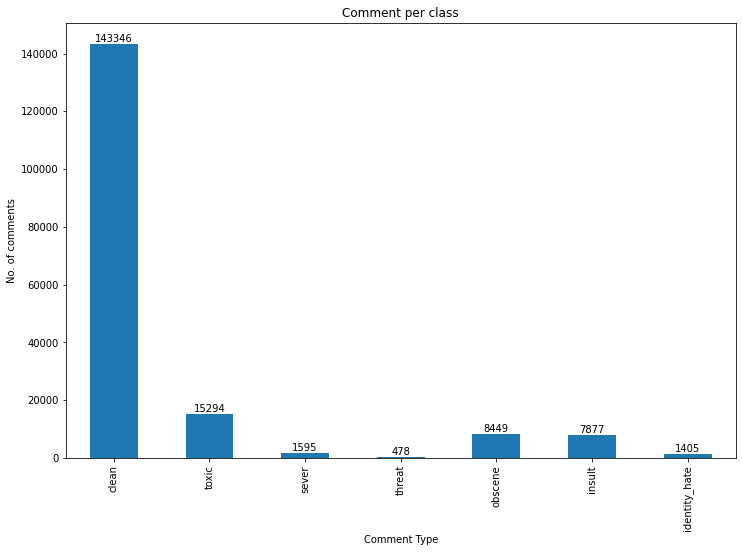

In [ ]:
#https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
# Calculating the Number of each categories

clean = len(data[(data["toxic"]==0) & (data["severe_toxic"]==0) & (data["obscene"]==0) & (data["threat"]==0) &(data["insult"]==0) & (data["identity_hate"]==0)]) 
toxic = len(data[data["toxic"]==1])
sever =  len(data[data["severe_toxic"]==1])
threat = len(data[data["threat"]==1]) 
obscene = len(data[data["obscene"]==1])
insult = len(data[data["insult"]==1])
identity_hate = len(data[data["identity_hate"]==1])
fr = [clean , toxic , sever , threat ,obscene , insult , identity_hate]

freq_series = pd.Series(fr)
x_labels = ["clean" , "toxic" , "sever" , "threat" ,"obscene" , "insult" , "identity_hate"]
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_title('Comment per class')
ax.set_xlabel("Comment Type")
ax.set_ylabel('No. of comments')
ax.set_xticklabels(x_labels)
rects = ax.patches


for rect , label in zip(rects , fr):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

### observation:
    
   1.) The data is highly imbalanced in nature and some of the points are very less like threat and identity hate.

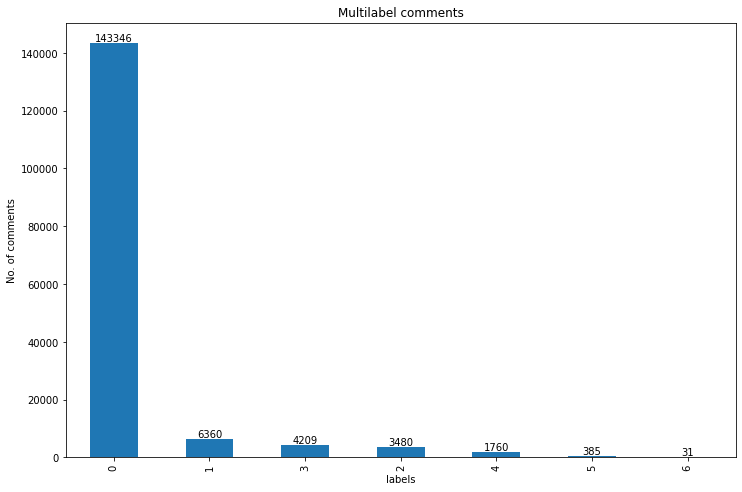

In [ ]:
x = data[["toxic" , "severe_toxic"  ,"obscene" , "threat" , "insult" , "identity_hate"]].sum(axis = 1).value_counts()#it written a dictionary
key = x.keys()
value = x.values

fr = pd.Series(value)
plt.figure(figsize=(12, 8))
ax = fr.plot(kind='bar')
ax.set_title('Multilabel comments')
ax.set_xlabel("labels")
ax.set_ylabel('No. of comments')
ax.set_xticklabels(key)
rects = ax.patches


for rect , label in zip(rects , fr):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

plt.show()

### Observation:

  1.) Most of the labels are sigle labeled in the data set.
  
  2.) Only 31 points are there which has all the three labesl.
   

## Creating new featurs:
  >1 .) Leangth of each comment

  >2 .) Total Number of uppercase latter in each comment

  >3 .) Number of Exclamation Punctuation

  >4 .) Number of Punctuation

  >5 .) Number of Symblols.

  >6 .) Number of Words

  >7 .) Number of Happy and Sad smilies.


In [ ]:
data['total_length'] = data['comment_text'].apply(len)

data['uppercase'] = data['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))

data['exclamation_punctuation'] = data['comment_text'].apply(lambda comment: comment.count('!'))

data['num_punctuation'] = data['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:?'))

data['num_symbols'] = data['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))

data['num_words'] = data['comment_text'].apply(lambda comment: len(comment.split()))

data['num_happy_smilies'] =data['comment_text'].apply(lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))

data['num_sad_smilies'] = data['comment_text'].apply(lambda comment: sum(comment.count(w) for w in (':-(', ':(', ';-(', ';(')))


In [ ]:
data.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_length,uppercase,exclamation_punctuation,num_punctuation,num_symbols,num_words,num_happy_smilies,num_sad_smilies
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,17,0,7,0,43,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,8,1,5,0,17,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,4,0,4,0,42,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622,11,0,6,0,113,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67,2,0,4,0,13,0,0


In [ ]:
fig = go.Figure()

fig.add_trace(go.Histogram(x=data.loc[data['toxic'] == 1].total_length, name='toxic'))
fig.add_trace(go.Histogram(x=data.loc[data['severe_toxic'] == 1].total_length, name='severe_toxic'))
fig.add_trace(go.Histogram(x=data.loc[data['obscene'] == 1].total_length, name='obscene'))
fig.add_trace(go.Histogram(x=data.loc[data['threat'] == 1].total_length, name='threat'))
fig.add_trace(go.Histogram(x=data.loc[data['insult'] == 1].total_length, name='insult'))
fig.add_trace(go.Histogram(x=data.loc[data['identity_hate'] == 1].total_length, name='identity hate'))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.5)
fig.show()


### Observation:
>1.) Almost all the points are following the perito distribution. In general    language follows.

>2 .) Very Few points have the length of comments very high.


## Checking how many type of toxicity each comment follow:

>To do that we are going to create a new column in existing matrix known as toxic type

In [ ]:
data['toxic_type'] = '' #Giving the empty space to the column

data['toxic_type'].loc[data['toxic'] == 1] += 'toxic ' 
#this will written a string as ['','toxic] at the place where the toxic==1

data['toxic_type'].loc[data['severe_toxic'] == 1] += 'severe_toxic '
#this will written a string as ['','toxic,sever_toxic] at the place where the sever_toxic==1

data['toxic_type'].loc[data['obscene'] == 1] += 'obscene '
#this will written a string as ['','toxic,sever_toxic,obscene] at the place where the obscene==1

data['toxic_type'].loc[data['threat'] == 1] += 'threat '
#this will written a string as ['','toxic,sever_toxic,obscene,threat] at the place where the sever_toxic==1

data['toxic_type'].loc[data['insult'] == 1] += 'insult '
#this will written a string as ['','toxic,sever_toxic,obscene,threat,insult] at the place where the sever_toxic==1

data['toxic_type'].loc[data['identity_hate'] == 1] += 'identity_hate ' 
#this will written a string as ['','toxic,sever_toxic,obscene,threat,inslut,identity_hate] at the place where the identity_hate==1

# counitng the total_toxic_type in each comment;
data['list_toxic_type'] = data['toxic_type'].apply(lambda row: row.split(' '))#splitting each string by space
data['list_toxic_type'] =data['list_toxic_type'].apply(lambda row: len(row)-1)#counting the number of cat. in each comment


data['list_toxic_type'].loc[data['list_toxic_type']==0] = 'normal comment'
data['list_toxic_type'].loc[data['list_toxic_type']==1] = 'has one type of toxic'
data['list_toxic_type'].loc[data['list_toxic_type']==2] = 'has two types of toxic'
data['list_toxic_type'].loc[data['list_toxic_type']==3] = 'has three types of toxic'
data['list_toxic_type'].loc[data['list_toxic_type']==4] = 'has four types of toxic'
data['list_toxic_type'].loc[data['list_toxic_type']==5] = 'has five types of toxic'
data['list_toxic_type'].loc[data['list_toxic_type']==6] = 'has six types of toxic'


## Creating the mean dataFrames On the basis of type of toxicty followed :




In [ ]:
types = ['normal comment', 'has one type of toxic', 'has two types of toxic', 'has three types of toxic',
         'has four types of toxic', 'has five types of toxic', 'has six types of toxic']

columns = ['total_length', 'uppercase', 'exclamation_punctuation',
                                'num_punctuation', 'num_symbols', 'num_happy_smilies', 'num_sad_smilies']

df_mean = pd.DataFrame(columns=columns)
for i, toxic_type in enumerate(types):
    for col in columns:    
        df_mean.at[i, col] = data[col].loc[data['list_toxic_type'] == toxic_type].mean()
df_mean['toxic_types'] = types 
df_mean.head(7)

,total_length,uppercase,exclamation_punctuation,num_punctuation,num_symbols,num_happy_smilies,num_sad_smilies,toxic_types
0,404.347,14.237,0.343442,8.63527,0.114332,0.00679475,0.000369735,normal comment
1,348.79,32.9997,2.57893,7.84009,0.145755,0.00707547,0.000628931,has one type of toxic
2,252.164,26.9325,1.77011,6.10345,0.135632,0.00287356,0.000574713,has two types of toxic
3,241.64,36.5308,3.64813,5.05037,0.14374,0.00617724,0.000712758,has three types of toxic
4,371.54,106.407,9.48636,6.15284,0.125,0.00340909,0.00340909,has four types of toxic
5,361.423,124.948,4.26494,7.03117,0.197403,0.012987,0,has five types of toxic
6,488.871,149.065,2.90323,13.0323,0,0,0,has six types of toxic


In [ ]:
df_mean['total_length'] = pd.to_numeric(df_mean['total_length'])
df_mean['uppercase'] = pd.to_numeric(df_mean['uppercase'])
df_mean['exclamation_punctuation'] = pd.to_numeric(df_mean['exclamation_punctuation'])
df_mean['num_punctuation'] = pd.to_numeric(df_mean['num_punctuation'])
df_mean['num_symbols'] = pd.to_numeric(df_mean['num_symbols'])
df_mean['num_happy_smilies'] = pd.to_numeric(df_mean['num_happy_smilies'])
df_mean['num_sad_smilies'] = pd.to_numeric(df_mean['num_sad_smilies'])
df_mean.head()

,total_length,uppercase,exclamation_punctuation,num_punctuation,num_symbols,num_happy_smilies,num_sad_smilies,toxic_types
0,404.347174,14.236993,0.343442,8.635274,0.114332,0.006795,0.000370,normal comment
1,348.789780,32.999686,2.578931,7.840094,0.145755,0.007075,0.000629,has one type of toxic
2,252.164080,26.932471,1.770115,6.103448,0.135632,0.002874,0.000575,has two types of toxic
3,241.639582,36.530767,3.648135,5.050368,0.143740,0.006177,0.000713,has three types of toxic
4,371.539773,106.406818,9.486364,6.152841,0.125000,0.003409,0.003409,has four types of toxic


In [ ]:
px.scatter(df_mean, x="exclamation_punctuation", y="num_punctuation",
           size="total_length", color="toxic_types", hover_name="toxic_types",
           size_max=55)

### Observation: 
> 1 .) Each cluster is giving us the information That each category can be seperate on the basis of Exclamation punction and Total num of punctuation.

> 2 .) This seperating is done on the basis of mean value so we can not be sure that this same will follow by each and every point.


## Creating a New mean dataframe for analysing each class

In [ ]:
types = ['toxic', 'severe_toxic', 'obscene', 'threat',
         'insult', 'identity_hate']

df_types_mean = pd.DataFrame(columns=columns)

In [ ]:
for i, toxic_type in enumerate(types):
    for col in columns:    
        df_types_mean.at[i, col] = data[col].loc[data[toxic_type] == 1].mean()

In [ ]:
for col in columns:    
        df_types_mean.at[6, col] = data[col].loc[data['toxic'] == 0] \
                                                        .loc[data['severe_toxic'] == 0] \
                                                        .loc[data['obscene'] == 0] \
                                                        .loc[data['threat'] == 0] \
                                                        .loc[data['insult'] == 0] \
                                                        .loc[data['identity_hate'] == 0] \
                                                        .mean()

In [ ]:
types.append('normal comment')

df_types_mean['type'] = types
df_types_mean

,total_length,uppercase,exclamation_punctuation,num_punctuation,num_symbols,num_happy_smilies,num_sad_smilies,type
0,295.246,44.1909,3.63169,6.33477,0.142997,0.00562312,0.000915392,toxic
1,453.635,154.927,16.2759,6.9837,0.189969,0.00438871,0.00250784,severe_toxic
2,286.785,50.5088,3.3301,6.07693,0.139306,0.00544443,0.00106521,obscene
3,307.741,76.2971,16.8222,7.44142,0.133891,0.0041841,0,threat
4,277.285,49.3298,3.7315,5.68402,0.119843,0.00507808,0.00139647,insult
5,308.541,72.0306,2.31174,5.47473,0.192883,0.00782918,0.00213523,identity_hate
6,404.347,14.237,0.343442,8.63527,0.114332,0.00679475,0.000369735,normal comment


In [ ]:
df_types_mean['total_length'] = pd.to_numeric(df_types_mean['total_length'])
df_types_mean['uppercase'] = pd.to_numeric(df_types_mean['uppercase'])
df_types_mean['exclamation_punctuation'] = pd.to_numeric(df_types_mean['exclamation_punctuation'])
df_types_mean['num_punctuation'] = pd.to_numeric(df_types_mean['num_punctuation'])
df_types_mean['num_symbols'] = pd.to_numeric(df_types_mean['num_symbols'])
df_types_mean['num_happy_smilies'] = pd.to_numeric(df_types_mean['num_happy_smilies'])
df_types_mean['num_sad_smilies'] = pd.to_numeric(df_types_mean['num_sad_smilies'])

In [ ]:
px.scatter(df_types_mean, x="exclamation_punctuation", y="num_punctuation",
           size="total_length", color="type", hover_name="type",
           size_max=55)

In [ ]:
fig = px.scatter_3d(df_types_mean, x='exclamation_punctuation', y='num_punctuation', z='uppercase', size='total_length', color='type',
                    hover_data=['type'])
fig.update_layout(scene_zaxis_type="log")
fig.show()

In [ ]:
px.scatter(df_types_mean, x="uppercase", y="num_punctuation",
           size="total_length", color="type", hover_name="type",
           size_max=55)

In [ ]:
px.scatter(df_types_mean, x="uppercase", y="num_symbols",
           size="total_length", color="type", hover_name="type",
           size_max=55)

In [ ]:
px.scatter(df_types_mean, x="uppercase", y="exclamation_punctuation",
           size="total_length", color="type", hover_name="type",
           size_max=55)

### Observation:
> 1 .) Looking at all the above plot we can see that when we do analysis on individual classes then different mean cluster overlap.

> 2 .) It means that the seperation is not easy not only on each data point individually but for mean value too.

> 3 .) Though in our 3d plot it is clearly seen that mean value can be seperated on the 3d axis but it is again giving us the seperation on basis of mean we can not comment for each individual data point 

## Checking whether Based on comment length can we make rigth label prediction;


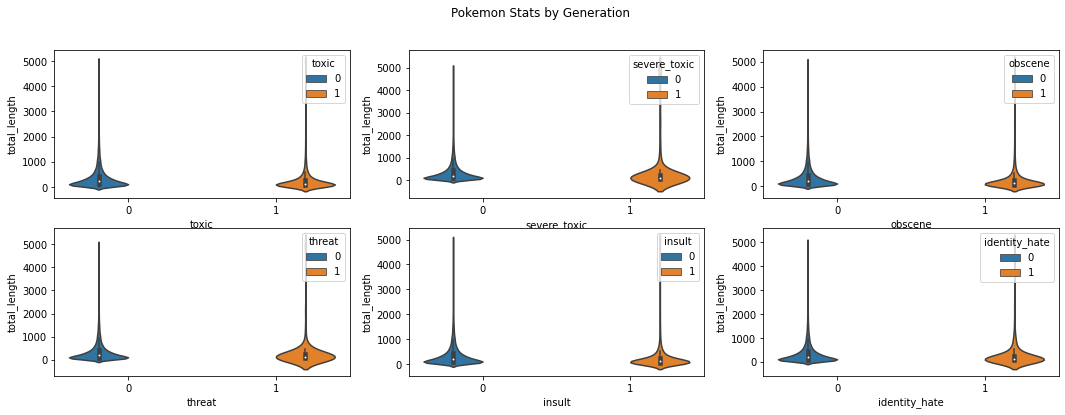

In [ ]:
lst = ['toxic',	'severe_toxic',	'obscene'	,'threat',	'insult',	'identity_hate']
f, axs = plt.subplots(2, 3 ,figsize=(18,6))
f.suptitle('Pokemon Stats by Generation')

sns.violinplot(x=lst[0], y="total_length", data=data , hue = lst[0], ax=axs[0][0])
sns.violinplot(x=lst[1], y="total_length", data=data , hue = lst[1], ax=axs[0][1])
sns.violinplot(x=lst[2], y="total_length", data=data , hue = lst[2], ax=axs[0][2])
sns.violinplot(x=lst[3], y="total_length", data=data , hue = lst[3], ax=axs[1][0])
sns.violinplot(x=lst[4], y="total_length", data=data , hue = lst[4], ax=axs[1][1])
sns.violinplot(x=lst[5], y="total_length", data=data , hue = lst[5], ax=axs[1][2])



### Observation:
> 1 .) The primary observation is that most of the data points in each category on the binary label scale does not differ.

> 2 .) There are certain categories like "Threat" and "Sever toxic" which has length plot slighlty bigger then their 0 label value but it only gives us rough estimation.

## Ploting The word cloud for Toxic categories and Clean category:

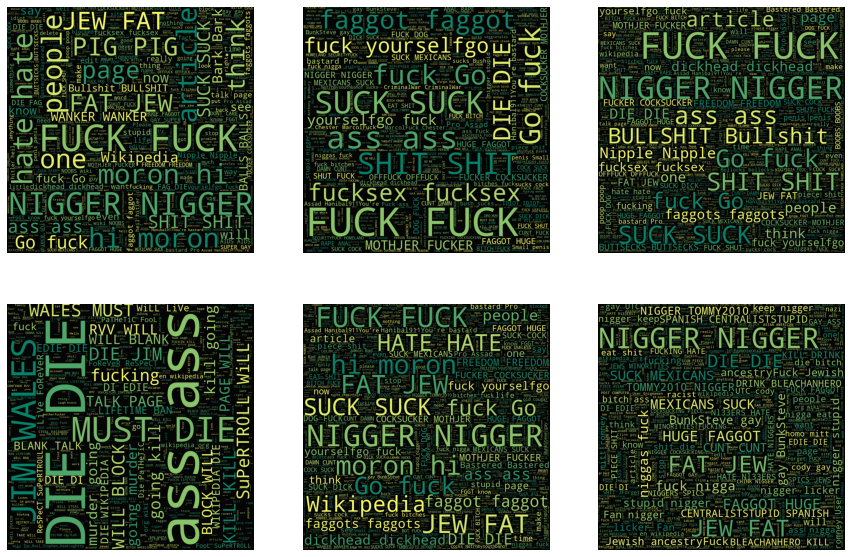

In [ ]:
#https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
figure, axes = plt.subplots(2, 3, figsize=(15, 10))
types = [['toxic',	'severe_toxic',	'obscene',]	,['threat',	'insult',	'identity_hate']]

for r in range(2):
    for c in range(3):
      toxic_data = data[data[types[r][c]]==1]
      str1 = ''.join(toxic_data['comment_text'])
      wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', max_words=2000,
                stopwords = STOPWORDS).generate(str1) 
  
# plot the WordCloud image
      ax = axes[r][c]                        
      #ax.figure(figsize = (8, 8), facecolor = None)
      ax.imshow(wordcloud.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)
      #plt.imshow(wordcloud) 
      ax.axis("off") 
      #plt.tight_layout(pad = 0)
  
plt.show() 

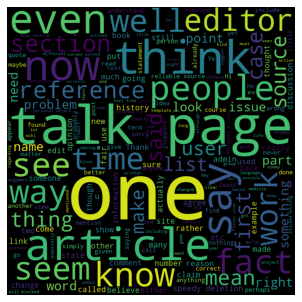

In [ ]:
clean_data = data[(data["toxic"]==0)&(data["severe_toxic"]==0)&(data["obscene"]==0)&(data["insult"]==0)&(data["threat"]==0)&(data["identity_hate"]==0)]#
## extracting all the clean comments from the original data

str1 = ''.join(clean_data['comment_text'])
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = STOPWORDS).generate(str1) 
  
# plot the WordCloud image                        
plt.figure(figsize = (4,4), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Observation:
> 1 .) Most of the words in the words in the toxic categories are similar.

> 2 .) They are only different in the occuerrence.

> 3 .) In the category threat the word "DIE" occur many times then the other words.

> 4 .) In normal comments there are not a single toxic word.
 


## Spliting the Data set for train and CV:

In [ ]:
from sklearn.model_selection import train_test_split

train, cv = train_test_split(data, test_size = 0.2)

## Preprocessing and Cleaning the data

In [ ]:
def preprocessing(data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sent in tqdm(data['comment_text'].values):
        sent = sent.lower()
        preprocessed_text.append(sent.strip())
    return preprocessed_text

In [ ]:
train['comment_text'] = preprocessing(train)
cv['comment_text'] = preprocessing(cv)
test['comment_text'] = preprocessing(test)

100%|██████████| 153164/153164 [00:00<00:00, 973755.03it/s] 


In [ ]:
train.shape, cv.shape, test.shape

((127656, 8), (31915, 8), (153164, 2))

__Making functions:__
1. check_coverage is where text goes through the given vocabulary and tries to find word vectors in your embedding matrix.
2. build_vocab builds a ordered dictionary of words and their frequency in your text corpus.
3. loading glove model

In [ ]:
import operator 

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

In [ ]:
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [ ]:
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        try:
            splitLine = line.split()
            embedding = np.array([float(val) for val in splitLine[1:]])
            model[splitLine[0]] = embedding
        except:
            continue
    print ("Done.",len(model)," words loaded!")
    return model

In [ ]:
model1 = loadGloveModel('glove.42B.300d.txt')

2418it [00:00, 12170.30it/s]

Loading Glove Model


1917495it [02:34, 12417.83it/s]

Done. 1917495  words loaded!


In [ ]:
vocab = build_vocab(list(train['comment_text'].apply(lambda x:x.split())))
oov = check_coverage(vocab,model1)
oov[:10]

100%|██████████| 403716/403716 [00:00<00:00, 776200.43it/s]

Found embeddings for 26.95% of vocab
Found embeddings for  88.43% of all text


[('(utc)', 4640),
 ('article,', 4452),
 ('•', 4308),
 ('page,', 4265),
 ('(talk)', 3393),
 ("isn't", 3232),
 ('also,', 2723),
 ('so,', 2609),
 ('again,', 2588),
 ('wikipedia,', 2455)]

In [ ]:
latin_similar = "’'‘ÆÐƎƏƐƔĲŊŒẞÞǷȜæðǝəɛɣĳŋœĸſßþƿȝĄƁÇĐƊĘĦĮƘŁØƠŞȘŢȚŦŲƯY̨Ƴąɓçđɗęħįƙłøơşșţțŧųưy̨ƴÁÀÂÄǍĂĀÃÅǺĄÆǼǢƁĆĊĈČÇĎḌĐƊÐÉÈĖÊËĚĔĒĘẸƎƏƐĠĜǦĞĢƔáàâäǎăāãåǻąæǽǣɓćċĉčçďḍđɗðéèėêëěĕēęẹǝəɛġĝǧğģɣĤḤĦIÍÌİÎÏǏĬĪĨĮỊĲĴĶƘĹĻŁĽĿʼNŃN̈ŇÑŅŊÓÒÔÖǑŎŌÕŐỌØǾƠŒĥḥħıíìiîïǐĭīĩįịĳĵķƙĸĺļłľŀŉńn̈ňñņŋóòôöǒŏōõőọøǿơœŔŘŖŚŜŠŞȘṢẞŤŢṬŦÞÚÙÛÜǓŬŪŨŰŮŲỤƯẂẀŴẄǷÝỲŶŸȲỸƳŹŻŽẒŕřŗſśŝšşșṣßťţṭŧþúùûüǔŭūũűůųụưẃẁŵẅƿýỳŷÿȳỹƴźżžẓ"
white_list = string.ascii_letters + string.digits + latin_similar + ' '
white_list += "'"

In [ ]:
glove_chars = ''.join([c for c in tqdm(model1) if len(c) == 1])
glove_symbols = ''.join([c for c in glove_chars if not c in white_list])
glove_symbols

100%|██████████| 1917495/1917495 [00:00<00:00, 3521517.09it/s]


',.":)(-!?|;$&/[]>%=#+@~£\\_{}^`<€›½…“”–¢¡¿―¥—‹¼¤¾、»。‟￥«฿ª˚ƒˈˑ⅓˜₤ˆ￡₂˙؟˝⅛„ɡ۞๑⅔ˌﾟ⅜‛܂⁰ở⅝ﬁ̅͡۩αʈ⅞ɪ￦;̣˛٠₃ȃ‚ν۶ǡʿʃ₁βʤ˘٩̵￠в̶ǥλ２δ٤۵ˇ۲́１ー۰ƃɔɑ̂ǀω۱ʡʊ̃日⁴ʒ̳３։μɂ₄θɨｏͧ年ǰφȥ７ɿـγʌǂʻɐﬂǹ̿̊ƥɒиπ４ɹаｓ̏ʔσａｉȡǵはǩ⁵̀ʹ５ᴥ߂˃˹ȣ͂ｗ̄ȭȿｍɤȸсƽ₀ｃạε⁶の๐月̌ɾﾞ̸ʘɸȫ⁸⅕̾₆ｖτʕȯ܀ː΄６ˤǫ๖ｐ̱ͤ١۳̎⁷ɩổ̐̓ρƪ̷ˉʞ₅ɚɯʺɲ\u06ddɻ˂ˡ位ʹʂｂ８ǭ⅙ʧ９ʐｑʋ۴̗̕ʱƶǁ˻̴ｔḳｘǯɵʀȱ号'

___
__Note:__ So lets have closer look on what we just did. We printed all symbols that we have an embedding vector for. Intrestingly its not only a vast amount of punctuation but also emojis and other symbols. Especially when doing sentiment analysis emojis and other symbols carrying sentiments should not be deleted! What we can delete are symbols we have no embeddings for. So lets check the characters in our texts and find those to delete:
___

In [ ]:
jigsaw_chars = build_vocab(list(train["comment_text"]))
jigsaw_symbols = ''.join([c for c in jigsaw_chars if not c in white_list])
jigsaw_symbols

100%|██████████| 127656/127656 [00:04<00:00, 29660.75it/s]


',\n:/.?"-!()—•*=[]@|✍\\_>;+%–&\xa0“”`~{}°χεῖρς★#琉竜·<♫♦♠\uf0a7聖や☼брайенאמר→←≈$^…″✆✈⋅龙α®\u200e☎☘☤ᛏ¢©−¡笑う犬の冒険\u3000（§™ɑ✉球南西►ωηλουνιτδφβγμκσ➨❝❞あっ女神さまそれぞ翼☮´ʘ屌你老母кстовздижящёмлп窣堵坡«└┐\x93\x94†ψ「✎」♥♪➔∇∆雲\u200d水明溪！✔º‽↔₪₩𒁳όπάξ📞📧ίˌɪˈɔːɡ‧\u2002☺☭專科年普通大學制在職班×ựứхъ⨹↑↓іцѕ、🍁µ♣№☏₂»€ʍɐ⇔¦⇒頭ˉ╦╩連絡見学迷惑∙。，：干什么？ζή̇先生┘┌\u2060⊕⊗ύ⁄ツʊɹ⚇♔😜किपलदेव‡эгь😂¿′¬߷♀עשתהדבו世祖ውይትǰʿتوفانॐ☥ычу❤☯ऋ｡◕‿✄\ufeff\u2009ҝार्तθهشکگزجآرد☆✰\x95¤≠∞℥\xadمحّلعبسي‹›步驚心電視劇☠₵₡²±≤₨₳ɖ⊝כ⊙✽आयशीसפלגיצקנחזןסםʞʇªὀὺὸἐ᾽ὄὅἴὰώἱἀἠὲὶῷἔ„महषटṗṫṁ▫धोك龍\uf6fc\uf701ंघṯʾ¯¸¨\u202f\u2003≽ʌⱷ҅ᴥ≼қ野您好歡迎來訪英文版的維基百雖然我們隨時編輯但是這次執筆所使用並未達到需求準若不介意話可以中感謝參加ຄົນລາວຸ່ມແະພງສທອັກິດີຈປຊໄຕຫຼູຣໂໜຮਸੁਖグレン\u200b£∫أخصةقئطىثءغ،ًضظُذإ☸¹ɰɯ♬♩ү☿【遯卋山人】よ独断と偏で選んだ받침ㅅㄷ࿓ї́💬ɿ―ღ田代し波瀾万丈伝কুমিল্াভটোরয়সেজ馬长颈鹿ừế۞ʧѓќђћџшј投稿█▪🗽内ℱюׁʕ对话页会記録メール২০১きなおɳ☝翁ϛ\x97●✓ʉ₦฿₮）张金柱ầ╟─╢⁂ἰ◁ウド６８∪∈∴÷͡ʃʒی臭妈烂ὂ梨酸钾✤ٔ占地☛說嗎㎥市έ\u200aф排便மல்கழிதạệभगडॉजऔअ庄子和蝴蝶∅一擲千उझनुूँ四粿紅龜影武者₭\u202a\u202c🍌王調유헌劉憲太守↗ǖ½吗ˑ健ジョ・ワシト☻ṃử׀\uf0b7ɻ̃ⁿˡソニックザヘホ⚔¶て下い忍ộʁต่อยมวᵗᵃᵏ⁞ễờラヴパ塩谷定たにこ栗林慧くりば渡辺兼わべかねど折原恵はらけ豆१२३४५६७८९■ʨɢ𐌴𐌹𐌲𐌰𐌿ɩȋɱ梁智前永訣界चफ़ण०खबृठैइ😄臼井儀ṛ满清倒退论㊟ậ川河개는때려잡아야맛있다ი

In [ ]:
symbols_to_delete = ''.join([c for c in jigsaw_symbols if not c in glove_symbols])
symbols_to_delete

'\n•*✍\xa0°χῖς★琉竜·♫♦♠\uf0a7聖や☼брйенאמר→←≈″✆✈⋅龙®\u200e☎☘☤ᛏ©−笑う犬冒険\u3000（§™✉球南西►ηουικ➨❝❞あっ女神さまそれぞ翼☮´屌你老母ктозджящёмлп窣堵坡└┐\x93\x94†ψ「✎」♥♪➔∇∆雲\u200d水明溪！✔º‽↔₪₩𒁳όάξ📞📧ί‧\u2002☺☭專科普通大學制在職班×ựứхъ⨹↑↓іцѕ🍁µ♣№☏ʍ⇔¦⇒頭╦╩連絡見学迷惑∙，：干什么？ζή̇先生┘┌\u2060⊕⊗ύ⁄ツ⚇♔😜किपलदेव‡эгь😂′¬߷♀עשתהדבו世祖ውይትتوفانॐ☥ычу❤☯ऋ｡◕‿✄\ufeff\u2009ҝार्तهشکگزجآرد☆✰\x95≠∞℥\xadمحّلعبسي步驚心電視劇☠₵₡²±≤₨₳ɖ⊝כ⊙✽आयशीसפלגיצקנחזןסםʇὀὺὸἐ᾽ὄὅἴὰώἱἀἠὲὶῷἔमहषटṗṫṁ▫धोك龍\uf6fc\uf701ंघṯʾ¯¸¨\u202f\u2003≽ⱷ҅≼қ野您好歡迎來訪英文版的維基百雖然我們隨時編輯但是這次執筆所使用並未達到需求準若不介意話可以中感謝參加ຄົນລາວຸ່ມແະພງສທອັກິດີຈປຊໄຕຫຼູຣໂໜຮਸੁਖグレン\u200b∫أخصةقئطىثءغ،ًضظُذإ☸¹ɰ♬♩ү☿【遯卋山人】よ独断と偏で選んだ받침ㅅㄷ࿓ї💬ღ田代し波瀾万丈伝কুমিল্াভটোরয়সেজ馬长颈鹿ừếѓќђћџшј投稿█▪🗽内ℱюׁ对话页会記録メル২০১きなおɳ☝翁ϛ\x97●✓ʉ₦₮）张金柱ầ╟─╢⁂ἰ◁ウド∪∈∴÷ی臭妈烂ὂ梨酸钾✤ٔ占地☛說嗎㎥市έ\u200aф排便மல்கழிதệभगडॉजऔअ庄子和蝴蝶∅一擲千उझनुूँ四粿紅龜影武者₭\u202a\u202c🍌王調유헌劉憲太守↗ǖ吗健ジョ・ワシト☻ṃử׀\uf0b7ⁿソニックザヘホ⚔¶て下い忍ộʁต่อยมวᵗᵃᵏ⁞ễờラヴパ塩谷定たにこ栗林慧くりば渡辺兼わべかねど折原恵らけ豆१२३४५६७८९■ʨɢ𐌴𐌹𐌲𐌰𐌿ȋɱ梁智前永訣界चफ़ण०खबृठैइ😄臼井儀ṛ满清倒退论㊟ậ川河개는때려잡아야맛있다იხლეთ\x99\u2028△দℳคุก盒▲三國志卷吕布邈陈登臧洪後漢書焉袁術列傳都０ἡ∀《》ロチ😉聯ուրատɦʲɜɘˠʷ̯ɕ😢😃😊³✐�◔国本土ᵀᴬᴸᴷ討論ॆथὼ☽◯☾😀טாைீவுʝფʰპროსავ틀보호문서편집요청

In [ ]:
symbols_to_isolate = ''.join([c for c in jigsaw_symbols if c in glove_symbols])
symbols_to_isolate

',:/.?"-!()—=[]@|\\_>;+%–&“”`~{}ερ#<а$^…α¢¡のɑωλντδφβγμσʘсви«πˌɪˈɔːɡ年、₂»€ɐˉ。ʊɹ¿ǰʿθ¤‹›ʞª„ʌᴥ£ɯ́ɿ―۞ʧʕー฿６８͡ʃʒạ½ˑɻ̃ˡはɩ１ʈɨɤ̴˜ﬂ⁴⁰ɾ月号ƒˤ位日ʻ\u06dd۵۩ǀ¥¾ʀ⅓⅔¼⅛⅜⅝⅞₤ǫʡʔɸʂʐɲʋǂǁɵɚɒﾟﾞ'

In [ ]:
## creating a function to isolate and remove the above symbols from our data set.
tokenizer = TreebankWordTokenizer()

isolate_dict = {ord(c):f' {c} ' for c in symbols_to_isolate}
remove_dict = {ord(c):f'' for c in symbols_to_delete}

def handle_punctuation(x):
    x = x.translate(remove_dict)
    x = x.translate(isolate_dict)
    x = tokenizer.tokenize(x)
    x = ' '.join(x)
    return x

In [ ]:
train['comment_text'] = train['comment_text'].apply(lambda x:handle_punctuation(x))

In [ ]:
vocab = build_vocab(list(train['comment_text'].apply(lambda x:x.split())),verbose=False)
oov = check_coverage(vocab,model1)
oov[:10]

100%|██████████| 182607/182607 [00:00<00:00, 764882.03it/s]


Found embeddings for 63.73% of vocab
Found embeddings for  98.95% of all text


[('yourselfgo', 622),
 ('f5fffa', 566),
 ('bullshitbullshit', 412),
 ('hanibal911you', 366),
 ('articlemanual', 348),
 ("'image", 333),
 ('deneid', 331),
 ("'fuck", 322),
 ('wikipediahow', 306),
 ('criminalwar', 279)]

In [ ]:
cv['comment_text'] = cv['comment_text'].apply(lambda x:handle_punctuation(x))

In [ ]:
test['comment_text'] = test['comment_text'].apply(lambda x:handle_punctuation(x))

## Creating Word2vec for comments:


In [ ]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('gdrive/My Drive/Colab Notebooks/Yagvendra/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
def w2v(data):
    # average Word2Vec
    # compute average word2vec for each review.
    avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(data['comment_text'].values): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        avg_w2v_vectors.append(vector)

    return avg_w2v_vectors

In [ ]:
train_comment = w2v(train)
cv_comment = w2v(cv)
test_comment = w2v(test)

100%|██████████| 153164/153164 [00:11<00:00, 12888.01it/s]


In [ ]:
train_label = train[['toxic',	'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate']].values
cv_label = cv[['toxic',	'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate']].values

## Base Model as Random Forest:

### Hyperparameter Tunning1:

In [ ]:
train_auc = []
cv_auc = []
hyper_parameter = []
max_depth = [4, 6, 8, 10]
n_estimators = [10, 50, 100, 150]
for i in tqdm(n_estimators):
    for j in max_depth:        
        forest =  RandomForestClassifier(class_weight="balanced", max_depth=j, n_estimators=i)
        multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
        multi_target_forest.fit(train_comment, train_label)
     
        train_pred = multi_target_forest.predict_proba(train_comment)
        train_pred = np.transpose([pred[:, 1] for pred in train_pred])
    
        cv_pred = multi_target_forest.predict_proba(cv_comment)
        cv_pred = np.transpose([pred[:, 1] for pred in cv_pred])
        
        hyper_parameter.append((i,j))
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
        train_auc.append(roc_auc_score(train_label, train_pred, average=None))
        cv_auc.append(roc_auc_score(cv_label, cv_pred, average=None))

100%|██████████| 4/4 [1:12:35<00:00, 1088.94s/it]


In [ ]:
auc_t = []
for i in range(len(train_auc)): 
   auc_t.append(np.average(train_auc[i])) 

In [ ]:
auc_c = []
for i in range(len(cv_auc)):
    auc_c.append(np.average(cv_auc[i]))

In [ ]:
#https://www.geeksforgeeks.org/python-unzip-a-list-of-tuples/
res = list(zip(*hyper_parameter))
a = {'min_sample_split':res[0], 'max_depth':res[1],'Train_auc':auc_t,'CV_auc':auc_c}
df = pd.DataFrame(a)
df

,min_sample_split,max_depth,Train_auc,CV_auc
0,10,4,0.911207,0.897827
1,10,6,0.935971,0.908398
2,10,8,0.959688,0.908729
3,10,10,0.978914,0.905022
4,50,4,0.919854,0.907362
5,50,6,0.943567,0.919238
6,50,8,0.966206,0.925557
7,50,10,0.984539,0.926668
8,100,4,0.921233,0.908511
9,100,6,0.944404,0.920226


## Training on the best parameter:

In [ ]:
forest = RandomForestClassifier(random_state=1, class_weight="balanced", max_depth=10, n_estimators=150)
multi_target_forest = MultiOutputClassifier(forest, n_jobs=-1)
multi_target_forest.fit(train_comment, train_label)

MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight='balanced',
                                                       criterion='gini',
                                                       max_depth=10,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
              

In [ ]:
pred_train = multi_target_forest.predict_proba(train_comment)
pred_train = np.transpose([pred[:, 1] for pred in pred_train])

In [ ]:
pred_cv = multi_target_forest.predict_proba(cv_comment)
pred_cv = np.transpose([pred[:, 1] for pred in pred_cv])

## Visualizing the Result:

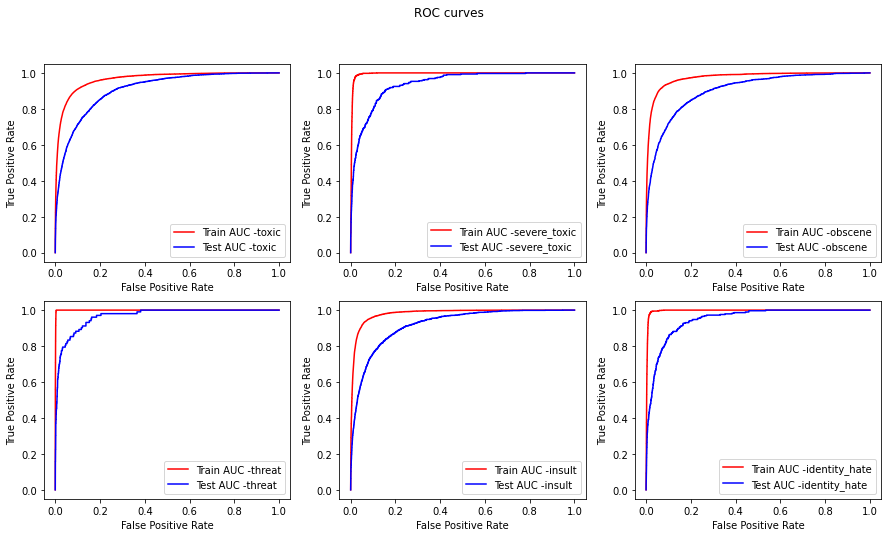

In [ ]:
lst = ['toxic',	'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate']

f, ax = plt.subplots(nrows=2, ncols=3)
f.suptitle('ROC curves')

i=0
for row in ax:
    for col in row:
        train_fpr, train_tpr, _ = roc_curve(train_label[:,i], pred_train[:,i])
        cv_fpr, cv_tpr, _ = roc_curve(cv_label[:,i], pred_cv[:,i])

        col.plot(train_fpr, train_tpr, 'r', label='Train AUC -' + str(lst[i]))
        col.plot(cv_fpr, cv_tpr, 'b', label='Test AUC -'  + str(lst[i]))
        col.legend(loc='lower right')
        i+=1

for a in ax.flat:
    a.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

f.set_figheight(8)
f.set_figwidth(15)
plt.show()

## Creating the Submission File:

In [ ]:
test_label = pd.read_csv("gdrive/My Drive/Colab Notebooks/Yagvendra/test_labels.csv")
test_label.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [ ]:
pred_test = multi_target_forest.predict_proba(test_comment)
pred_test = np.transpose([pred[:, 1] for pred in pred_test])

sub = pd.DataFrame(pred_test , columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

sub["id"] = test_label["id"].values
sub.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,id
0,0.948247,0.828153,0.924351,0.679447,0.926042,0.934367,00001cee341fdb12
1,0.321069,0.076676,0.298232,0.005033,0.254867,0.074277,0000247867823ef7
2,0.134900,0.043762,0.153106,0.000038,0.110038,0.045283,00013b17ad220c46
3,0.150273,0.038963,0.095082,0.000038,0.089803,0.013430,00017563c3f7919a
4,0.250312,0.053535,0.224104,0.006186,0.194216,0.055858,00017695ad8997eb


In [ ]:
result = sub[["id",'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
result.to_csv("gdrive/My Drive/submission.csv" ,index=False)
result.tail()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
153159,fffcd0960ee309b5,0.423761,0.045518,0.317596,0.006552,0.245637,0.084929
153160,fffd7a9a6eb32c16,0.501035,0.147643,0.428375,0.108876,0.356332,0.158528
153161,fffda9e8d6fafa9e,0.125717,0.019052,0.096226,0.000038,0.069392,0.025506
153162,fffe8f1340a79fc2,0.127604,0.019578,0.099077,0.019438,0.102384,0.127027
153163,ffffce3fb183ee80,0.713037,0.228485,0.617230,0.061534,0.689144,0.282205


##  Extending the data set.

We saw a new way of extending the data set . This idea was proposed by the (Pavel Ostyakov) https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/48038, in this we can leverage the idea of google translator. The example of this is given below.

In [ ]:
translator = Translator()
encode = translator.translate(data.comment_text.values[0] , dest='fr').text
decode = translator.translate(encode , dest='en').text
print(data.comment_text.values[0])
print(decode)

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Explanation
Why have the changes made under my Hardcore Metallica Fan username been canceled? They were not vandalism, just the closing of some GAs after having voted in the FAC of New York Dolls. And don't delete the template from the talk page, because I'm now retired.


In [ ]:
translator = Translator()

train_es = []
train_de = []
train_fr = []

for i in range(len(data.comment_text.values)):
  encode_es = translator.translate(data.comment_text.values[0] , dest='es').text
  decode_es = translator.translate(encode_es , dest='en').text
  train_es.append(decode_es)

  encode_de = translator.translate(data.comment_text.values[0] , dest='de').text
  decode_de = translator.translate(encode_de , dest='en').text
  train_de.append(decode_de)

  encode_fr = translator.translate(data.comment_text.values[0] , dest='fr').text
  decode_fr = translator.translate(encode_fr , dest='en')
  train_fr.append(decode_fr)

## Loading the preprocessed file:

In [ ]:
train_es =  pd.read_csv("/gdrive/My Drive/Colab Notebooks/train_es.csv")
train_de =  pd.read_csv("/gdrive/My Drive/Colab Notebooks/train_de.csv")
train_fr =  pd.read_csv("/gdrive/My Drive/Colab Notebooks/train_fr.csv")
print(len(train_es))
print(len(train_de))
print(len(train_fr))

159571
159571
159571


## Creating the new data set with higher no. of data points

In [ ]:
new_train =  pd.concat([data ,train_fr  ,train_es ,train_de , test_data_new])
new_train = shuffle(new_train)
print(len(new_train))

In [ ]:
train_comment = new_train["comment_text"].values
cv_comment = test_data_new["comment_text"].values
test_comment  = test_data["comment_text"].values

## Loading the bert tokenizer and encoding the text in input format

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
padded_ids_train = []
mask_ids_train = []

for i in tqdm(range(len(train_comment))):
  encoding = tokenizer.encode_plus(train_comment[i]  , max_length = 128 , pad_to_max_length = True  ,do_lower_case = False)
  input_ids , attention_id = encoding["input_ids"] , encoding["attention_mask"] 
  #if len(input_ids) < max_len:
    #padded_ = [0]*((max_len) - len(input_ids))
  padded_ids_train.append(input_ids)
  #padded_ids.extend(padded_)
  mask_ids_train.append(attention_id)

100%|██████████| 702262/702262 [12:02<00:00, 971.62it/s] 


In [ ]:
padded_ids_cv = []
mask_ids_cv = []

for i in tqdm(range(len(cv_comment))):
  encoding = tokenizer.encode_plus(cv_comment[i]  , max_length = 128 , pad_to_max_length = True , do_lower_case = False )
  input_ids , attention_id = encoding["input_ids"] , encoding["attention_mask"]
  #if len(input_ids) < max_len:
    #padded_ = [0]*((max_len) - len(input_ids))
  padded_ids_cv.append(input_ids)
  #padded_ids.extend(padded_)
  mask_ids_cv.append(attention_id)

100%|██████████| 63978/63978 [01:08<00:00, 930.74it/s]


In [ ]:
padded_ids_test = []
mask_ids_test = []

for i in tqdm(range(len(test_comment))):
  encoding = tokenizer.encode_plus(test_comment[i]  , max_length = 128 , pad_to_max_length = True , do_lower_case = False )
  input_ids , attention_id = encoding["input_ids"] , encoding["attention_mask"]
  #if len(input_ids) < max_len:
    #padded_ = [0]*((max_len) - len(input_ids))
  padded_ids_test.append(input_ids)
  #padded_ids.extend(padded_)
  mask_ids_test.append(attention_id)

100%|██████████| 153164/153164 [02:37<00:00, 974.24it/s]


In [ ]:
#train_array = np.array(new_df["toxic"].values)
y_train = new_train.drop(["id" ,"comment_text"] , axis=1)

#test_array = np.array(test_data_new["toxic"].values)

In [ ]:
train_id = np.array(padded_ids_train)
train_mask = np.array(mask_ids_train)

test_id = np.array(padded_ids_test)
test_mask = np.array(mask_ids_test)

print(train_id.shape , test_id.shape)
print(train_mask.shape , test_mask.shape)

(702262, 128) (153164, 128)
(702262, 128) (153164, 128)


### Model 1.) 

### Architecture:

In [ ]:
input_1 = tf.keras.Input(shape = (128) , dtype=np.int32)

input_2 = tf.keras.Input(shape = (128) , dtype=np.int32)

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

output  = model([input_1 , input_2] , training = True )

answer = tf.keras.layers.Dense(6 , activation = tf.nn.sigmoid )(output[0])

model = tf.keras.Model(inputs = [input_1, input_2 ] , outputs = [answer])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_for_sequence_classifica ((None, 2),)         109483778   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 6)            18          tf_bert_for_sequence_classi

In [ ]:
%load_ext tensorboard

In [ ]:
!rm -rf /gdrive/My Drive/logs/

### Creating path for saving the model and tensorboard

In [ ]:
log_dir = "/gdrive/My Drive/logs/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
filepath = "/gdrive/My Drive/final_model.h5"
checkpoint = ModelCheckpoint(filepath=filepath,
                                  monitor='val_auc',
                                  verbose=1,
                                  save_best_only=True , mode = "max" , save_weights_only = True)

In [ ]:
#with strategy.scope():
#model = creat_model()
auc_score = AUC(multi_label=True)
model.compile(optimizer = Adam(lr = 3e-5),
                loss = tf.keras.losses.binary_crossentropy,
             metrics = [ auc_score])

In [ ]:
model.fit([train_id , train_mask] , y_train,
          validation_split = 0.1 , batch_size = 32, 
          epochs=3, callbacks = [tensorboard_callback , checkpoint]
)

### Train loss:

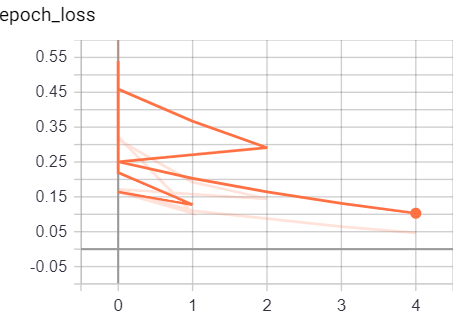

In [ ]:
Image(filename="C:\\Users\\my pc\\Pictures\\Screenshots\\Model_1 train loss.PNG")

### CV loss:

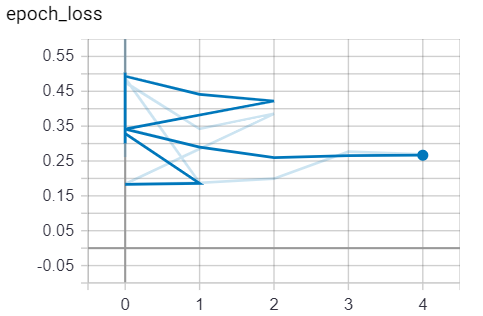

In [ ]:
Image(filename="C:\\Users\\my pc\\Pictures\\Screenshots\\Model_1 val loss.PNG")

### Model prediction and saving the output 

In [ ]:
model.load_weights("/gdrive/My Drive/final_model.h5")

In [ ]:
a = model.predict([test_id , test_mask])
sub = pd.DataFrame(a , columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

sub["id"] = test_data["id"].values
sub.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,id
0,0.996859,0.249085,0.988158,0.020886,0.978657,0.226216,00001cee341fdb12
1,0.000981,0.000043,0.000692,0.000128,0.000117,0.000079,0000247867823ef7
2,0.015035,0.000207,0.003353,0.000754,0.002331,0.000990,00013b17ad220c46
3,0.000158,0.000004,0.000095,0.000014,0.000013,0.000004,00017563c3f7919a
4,0.000236,0.000008,0.000170,0.000023,0.000025,0.000007,00017695ad8997eb


In [ ]:
result = sub[["id",'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
result.to_csv("/gdrive/My Drive/ninth_submission.csv" ,index=False)
result.tail()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
153159,fffcd0960ee309b5,0.496643,0.001046,0.182512,0.000676,0.031268,0.001175
153160,fffd7a9a6eb32c16,0.000931,0.000030,0.000584,0.000143,0.000087,0.000072
153161,fffda9e8d6fafa9e,0.000181,0.000004,0.000116,0.000018,0.000012,0.000005
153162,fffe8f1340a79fc2,0.000768,0.000047,0.000810,0.000115,0.000069,0.000082
153163,ffffce3fb183ee80,0.620240,0.004997,0.381507,0.002538,0.113429,0.006729


### Modle 2.)

### Architecture :

In [ ]:
def creat_model():
  
  input_1 = tf.keras.Input(shape = (128) , dtype=np.int32)

  input_2 = tf.keras.Input(shape = (128) , dtype=np.int32)

  model = TFBertModel.from_pretrained('bert-base-uncased')

  output , pooled_out  = model([input_1 , input_2] , training = True )

  x = tf.reshape(pooled_out , (-1 , pooled_out.shape[1]))

  dense_1 = tf.keras.layers.Dense(768   , activation= tf.nn.relu)(x)

  drop_1 = tf.keras.layers.Dropout(0.1)(dense_1)

  answer = tf.keras.layers.Dense(6 , activation = tf.nn.sigmoid)(drop_1)

  model = tf.keras.Model(inputs = [input_1, input_2 ] , outputs = [answer])

  return model

In [ ]:
model = creat_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   ((None, 128, 768), ( 109482240   input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Reshape_1 (TensorFl [(None, 768)]        0           tf_bert_model_1[0][1]      

In [ ]:
log_dir = "/gdrive/My Drive/logs/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
filepath = "/gdrive/My Drive/final_model3.h5"
checkpoint = ModelCheckpoint(filepath=filepath,
                                  monitor='val_auc',
                                  verbose=1,
                                  save_best_only=True , mode = "max" , save_weights_only = True)

In [ ]:
auc_score = AUC(multi_label=True)
model.compile(optimizer = Adam(lr = 3e-5),
                loss = tf.keras.losses.binary_crossentropy,
             metrics = [ auc_score])

In [ ]:
model.fit([train_id , train_mask] , y_train,
          validation_split = 0.1 , batch_size = 32, 
          epochs=3, callbacks = [tensorboard_callback , checkpoint]
)

### Train loss

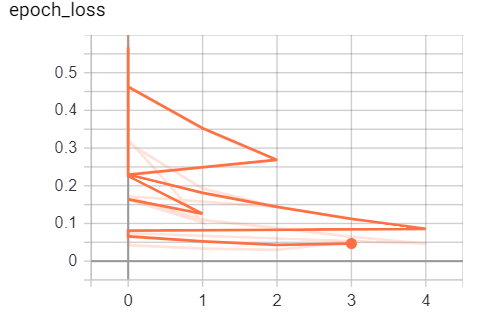

In [ ]:
Image(filename="C:\\Users\\my pc\\Pictures\\Screenshots\\Model_2 train loss.PNG")

### CV loss:

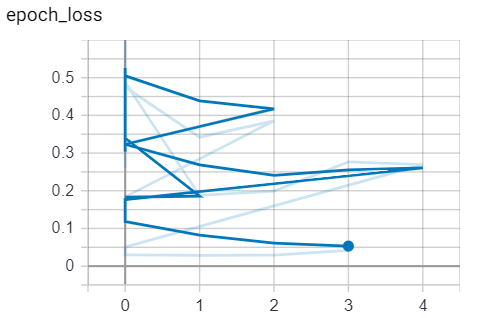

In [ ]:
Image(filename="C:\\Users\\my pc\\Pictures\\Screenshots\\Model_2 val loss.PNG")

## Creating file for submission:

In [ ]:
b = model.predict([test_id , test_mask])
sub = pd.DataFrame(b , columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
sub["id"] = test_data["id"].values
result = sub[["id",'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
result.to_csv("/gdrive/My Drive/13th_submission.csv" ,index=False)

In [ ]:
%tensorboard --logdir "/gdrive/My Drive/logs"

### Final result:

In [1]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model name", "Private_score", "public_score"]
x.add_row(["Base_model"        , 0.95139, 0.94209 ])
x.add_row(["Model_1"           , 0.98139, 0.98209 ])
x.add_row(["Model_2"           , 0.98951, 0.98931 ])
x.add_row(["Model_1 + Model_2" , 0.98971, 0.98993 ])

print(x)

+-------------------+---------------+--------------+
|     Model name    | Private_score | public_score |
+-------------------+---------------+--------------+
|     Base_model    |    0.95139    |   0.94209    |
|      Model_1      |    0.98139    |   0.98209    |
|      Model_2      |    0.98951    |   0.98931    |
| Model_1 + Model_2 |    0.98971    |   0.98993    |
+-------------------+---------------+--------------+
